In [1]:
!git clone https://github.com/meet-soni5720/covid_detection_from_xray

Cloning into 'covid_detection_from_xray'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 7999 (delta 7), reused 20 (delta 5), pack-reused 7975
Receiving objects: 100% (7999/7999), 1.06 GiB | 43.25 MiB/s, done.
Resolving deltas: 100% (8/8), done.
Checking out files: 100% (8578/8578), done.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import ImageGrid
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Dense, Dropout, BatchNormalization, MaxPooling2D, AveragePooling2D, Activation, Flatten
from tensorflow.keras.models import Model, load_model, save_model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import backend as K
import tqdm

In [4]:
os.listdir('covid_detection_from_xray')

['WebML_COVID_FROM_XRAY.ipynb',
 'README.md',
 'data_processing_for_covid_from_xray.ipynb',
 '.git',
 '.gitattributes',
 'data',
 'WebML']

In [5]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 10)

In [6]:
K.clear_session()

In [7]:
BATCH_SIZE = 32
EPOCH = 25

In [8]:
data_generator = ImageDataGenerator(
              rescale = 1./255,
              width_shift_range = 0.2,
              height_shift_range = 0.2,
              zoom_range = 0.2,
              brightness_range = [0.3, 1],
              validation_split = 0.2
)

test_data_gen = ImageDataGenerator(
                rescale = 1./255,
)

In [9]:
train_data = data_generator.flow_from_directory(
                            'covid_detection_from_xray/data/train',
                            target_size = (250, 250),
                            interpolation = "nearest",
                            color_mode = 'rgb',
                            class_mode = 'categorical',
                            batch_size = BATCH_SIZE,
                            seed = 42,
                            shuffle = True,
                            subset = "training",
)

Found 3600 images belonging to 3 classes.


In [10]:
val_data = data_generator.flow_from_directory(
                            'covid_detection_from_xray/data/train',
                            target_size = (250, 250),
                            interpolation = "nearest",
                            color_mode = 'rgb',
                            class_mode = 'categorical',
                            batch_size = BATCH_SIZE,
                            seed = 42,
                            shuffle = True,
                            subset = "validation",
)

Found 900 images belonging to 3 classes.


In [11]:
test_data = test_data_gen.flow_from_directory(
              'covid_detection_from_xray/data/test',
              target_size = (250,250),
              interpolation = 'nearest',
              color_mode = 'rgb',
              class_mode = 'categorical',
              shuffle = False,
)

Found 663 images belonging to 3 classes.


In [12]:
class_names = train_data.class_indices
print(class_names)
classes = list(class_names.keys())
print(classes)

{'covid19': 0, 'normal': 1, 'pneumonia': 2}
['covid19', 'normal', 'pneumonia']


In [13]:
train_step_size = train_data.n // BATCH_SIZE
val_step_size = val_data.n // BATCH_SIZE

In [14]:
x, y = next(train_data)
print(type(x))
print(type(y))
print(x.shape)
print(y.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(32, 250, 250, 3)
(32, 3)


In [15]:
def show_grid(image_list, nrows, ncols, class_names, label_list, show_label = False, figsize=(10,10), save_name = None):
  if type(image_list) is not list:
    if(image_list.shape[-1]==1):
        image_list = [image_list[i,:,:,0] for i in range(image_list.shape[0])]
    elif(image_list.shape[-1]==3):
        image_list = [image_list[i,:,:,:] for i in range(image_list.shape[0])]
  fig = plt.figure(None, figsize,frameon=False)
  grid = ImageGrid(fig, 111,  # similar to subplot(111)
                    nrows_ncols=(nrows, ncols),  # creates 2x2 grid of axes
                    axes_pad=0.3,  # pad between axes in inch.
                    share_all=True,
                    )
  batch_size = len(image_list)
  for i in range(min(nrows*ncols, batch_size)):
    # print(i)
    ax = grid[i]
    ax.imshow(image_list[i])  # The AxesGrid object work as a list of axes.
    ax.axis('off')
    if show_label:
      #print(label_list[i].shape)
      ind = np.argmax(label_list[i], axis = 0)
      ax.set_title(class_names[ind])

  if save_name != None:
    plt.savefig(save_name, bbox_inches = 'tight')

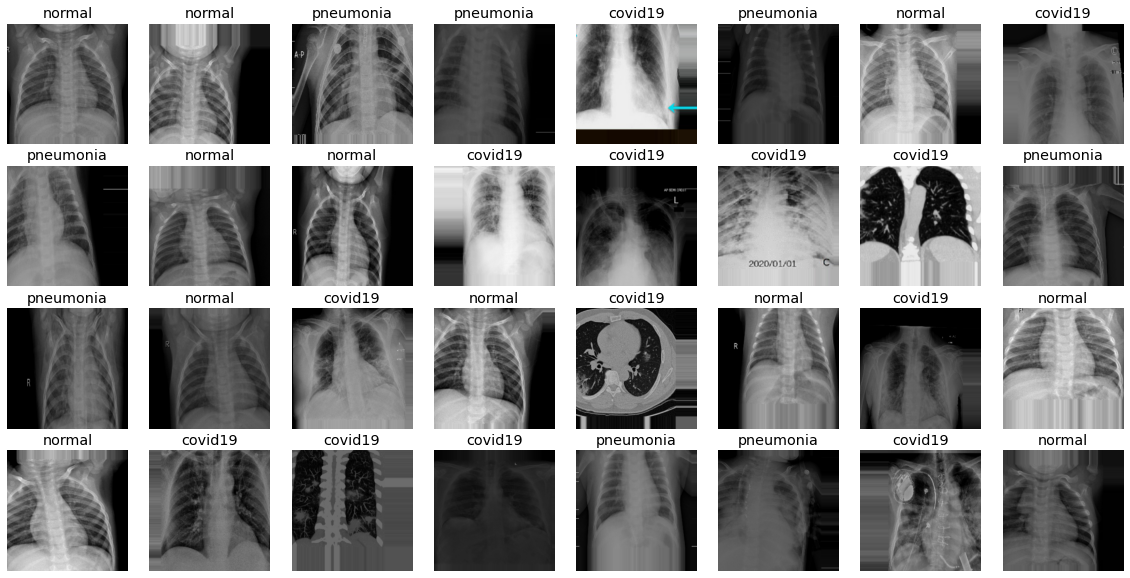

In [16]:
show_grid(x, 4, 8, classes, y, show_label = True, figsize = (20,20))

In [20]:
#building model
input_shape = (250, 250, 3)
num_classes = 3

model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', input_shape = input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(32, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(64, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(128, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(num_classes, activation='softmax'))

model.summary()
adam = Adam(learning_rate = 0.001)
model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 250, 250, 32)      896       
_________________________________________________________________
batch_normalization_7 (Batch (None, 250, 250, 32)      128       
_________________________________________________________________
activation_7 (Activation)    (None, 250, 250, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 250, 250, 32)      9248      
_________________________________________________________________
batch_normalization_8 (Batch (None, 250, 250, 32)      128       
_________________________________________________________________
activation_8 (Activation)    (None, 250, 250, 32)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 125, 125, 32)     

In [21]:
callbacks = [ReduceLROnPlateau(factor=0.2, patience=3, verbose=1)]

In [19]:
history = model.fit(
    train_data,
    steps_per_epoch = train_step_size,
    epochs = EPOCH,
    callbacks = callbacks,
    validation_data = val_data,
    validation_steps = val_step_size,
    verbose = 1,
)

Epoch 1/25
112/112 [==============================] - 84s 677ms/step - loss: 0.8970 - accuracy: 0.6705 - val_loss: 2.9063 - val_accuracy: 0.3326
Epoch 2/25
112/112 [==============================] - 75s 669ms/step - loss: 0.4264 - accuracy: 0.8449 - val_loss: 2.9675 - val_accuracy: 0.3337
Epoch 3/25
112/112 [==============================] - 75s 667ms/step - loss: 0.3427 - accuracy: 0.8717 - val_loss: 2.7796 - val_accuracy: 0.4107
Epoch 4/25
112/112 [==============================] - 75s 670ms/step - loss: 0.2915 - accuracy: 0.8811 - val_loss: 0.8794 - val_accuracy: 0.6663
Epoch 5/25
112/112 [==============================] - 75s 668ms/step - loss: 0.2616 - accuracy: 0.9065 - val_loss: 0.3087 - val_accuracy: 0.8839
Epoch 6/25
112/112 [==============================] - 75s 668ms/step - loss: 0.2505 - accuracy: 0.9068 - val_loss: 0.3087 - val_accuracy: 0.8873
Epoch 7/25
112/112 [==============================] - 76s 676ms/step - loss: 0.2401 - accuracy: 0.9136 - val_loss: 0.2331 - val_ac

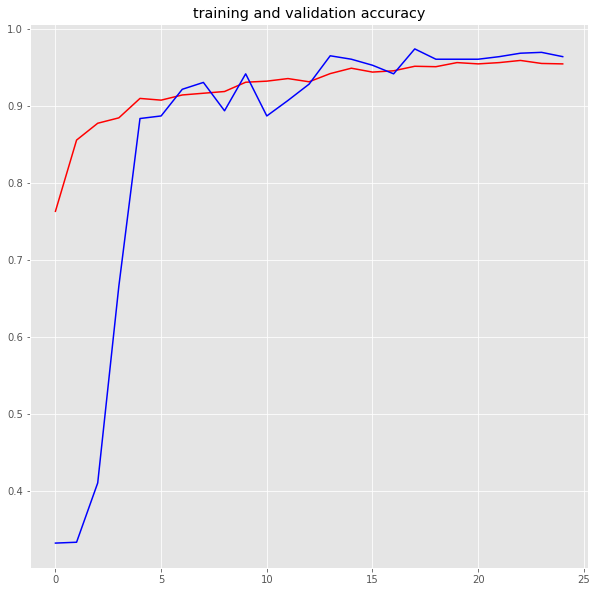

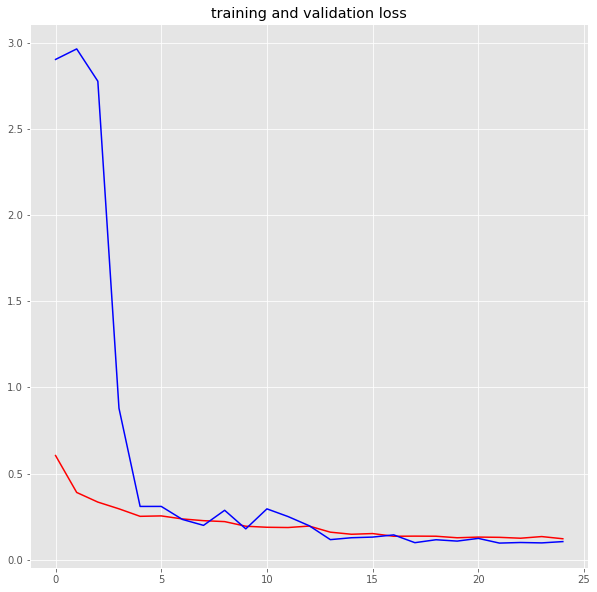

In [22]:
acc = history.history['accuracy']
loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epoch = EPOCH
epoch = [i for i in range(epoch)]
plt.plot(epoch, acc, color = 'r', label="training accuracy")
plt.plot(epoch, val_acc, color = 'b', label = "validation accuracy")
plt.title('training and validation accuracy')
plt.show()

plt.plot(epoch, loss, color = 'r', label = "training loss")
plt.plot(epoch, val_loss, color = 'b', label = "validation loss")
plt.title('training and validation loss')
plt.show()

In [23]:
model.save('gdrive/MyDrive/cv1.h5')

In [24]:
#Utilizing transfer learning
from tensorflow.keras.applications import ResNet50

In [25]:
EPOCH = 2
num_classes = 3
#fine tuning the model
model = ResNet50(include_top=False, weights='imagenet', input_shape=(250,250,3))
for layer in model.layers:
  layer.trainable = True

x = model.output
x = Flatten()(x)
x = Dense(units=256,activation="relu",kernel_regularizer = keras.regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(units=128,activation="relu",kernel_regularizer = keras.regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(units=128,activation="relu",kernel_regularizer = keras.regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
output = Dense(units=num_classes,activation="softmax")(x)

model = Model(inputs=model.input, outputs=output)
model.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 250, 250, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 125, 125, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 125, 125, 64) 256         conv1_conv[0][0]                 
_____________________________

In [26]:
adam = Adam(learning_rate = 0.001)
model.compile(optimizer = adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

callbacks = [ReduceLROnPlateau(factor=0.2, patience=3, verbose=1)]

In [27]:
history = model.fit(train_data,
              steps_per_epoch = train_step_size,
              epochs = 20,
              validation_data = val_data,
              validation_steps = val_step_size,
              verbose = 1,
              callbacks = callbacks,
              )

Epoch 1/20
112/112 [==============================] - 94s 786ms/step - loss: 10.6302 - accuracy: 0.7403 - val_loss: 5.9340 - val_accuracy: 0.3337
Epoch 2/20
112/112 [==============================] - 86s 767ms/step - loss: 3.7939 - accuracy: 0.9062 - val_loss: 3.4728 - val_accuracy: 0.3348
Epoch 3/20
112/112 [==============================] - 86s 769ms/step - loss: 2.1731 - accuracy: 0.9003 - val_loss: 2.4617 - val_accuracy: 0.3326
Epoch 4/20
112/112 [==============================] - 86s 769ms/step - loss: 1.4273 - accuracy: 0.9248 - val_loss: 2.3362 - val_accuracy: 0.3337
Epoch 5/20
112/112 [==============================] - 86s 766ms/step - loss: 0.9876 - accuracy: 0.9343 - val_loss: 2.6638 - val_accuracy: 0.3326
Epoch 6/20
112/112 [==============================] - 86s 764ms/step - loss: 0.8221 - accuracy: 0.9275 - val_loss: 2.3844 - val_accuracy: 0.3471
Epoch 7/20
112/112 [==============================] - 86s 768ms/step - loss: 0.8132 - accuracy: 0.9284 - val_loss: 2.8448 - val_a

In [28]:
model.save('gdrive/MyDrive/c_v2.h5')

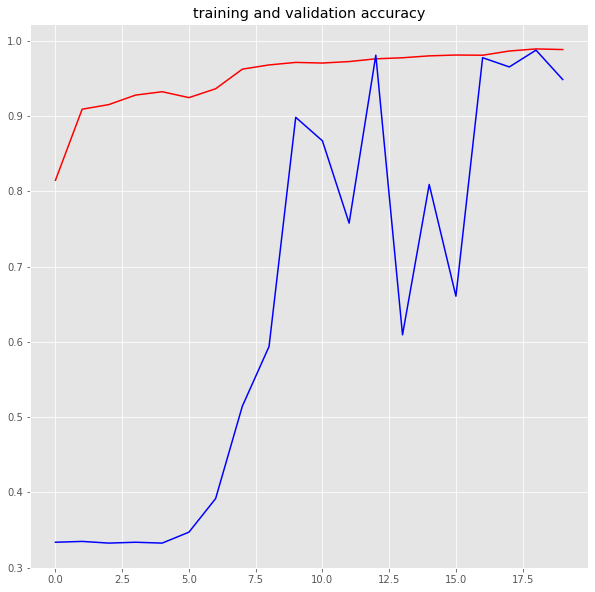

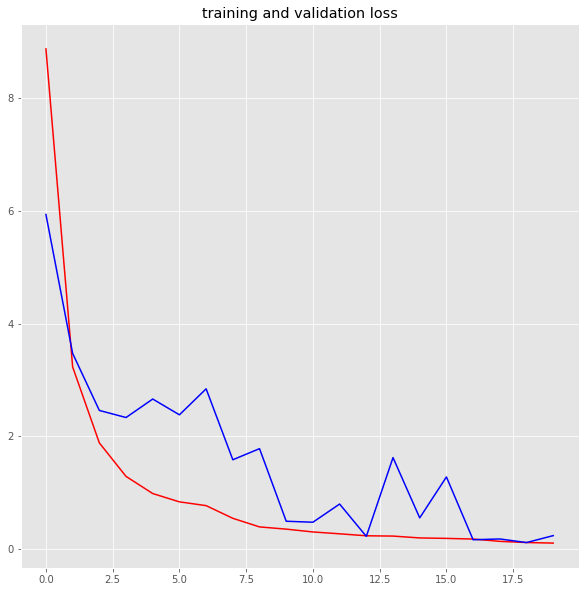

In [29]:
EPOCH = 20
acc = history.history['accuracy']
loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epoch = EPOCH
epoch = [i for i in range(epoch)]
plt.plot(epoch, acc, color = 'r', label="training accuracy")
plt.plot(epoch, val_acc, color = 'b', label = "validation accuracy")
plt.title('training and validation accuracy')
plt.show()

plt.plot(epoch, loss, color = 'r', label = "training loss")
plt.plot(epoch, val_loss, color = 'b', label = "validation loss")
plt.title('training and validation loss')
plt.show()

In [30]:
m1 = load_model('gdrive/MyDrive/c_v2.h5')

In [31]:
#test results for 2nd model
Y_pred = model.predict(test_data, verbose=1)

21/21 [==============================] - 7s 299ms/step


In [32]:
test_data.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1, 'covid19': 2}

In [33]:
y_pred = np.argmax(Y_pred, axis=1)
for i in range(len(y_pred)):
  if (y_pred[i] == 0):
    y_pred[i] = 2
  elif (y_pred[i] == 1):
    y_pred[i] = 0
  else:
    y_pred[i] = 1

#plotting confusion matrix
print('Confusion Matrix')
print(confusion_matrix(test_data.classes, y_pred))

#plt.imshow(confusion_matrix(test_data.classes, y_pred), cmap='magma')

#classification report 
print('Classification Report') 
target_names =['Normal', 'Pneunomonia', 'covid-19'] 
print(classification_report(test_data.classes, y_pred, target_names=target_names))

Confusion Matrix
[[241   1   0]
 [120 278   0]
 [  0   0  23]]
Classification Report
              precision    recall  f1-score   support

      Normal       0.67      1.00      0.80       242
 Pneunomonia       1.00      0.70      0.82       398
    covid-19       1.00      1.00      1.00        23

    accuracy                           0.82       663
   macro avg       0.89      0.90      0.87       663
weighted avg       0.88      0.82      0.82       663



In [34]:
#test results for 2nd model
m1 = load_model('gdrive/MyDrive/cv1.h5')

Y_pred = model.predict(test_data, verbose=1)
y_pred = np.argmax(Y_pred, axis=1)
for i in range(len(y_pred)):
  if (y_pred[i] == 0):
    y_pred[i] = 2
  elif (y_pred[i] == 1):
    y_pred[i] = 0
  else:
    y_pred[i] = 1

#plotting confusion matrix
print('Confusion Matrix')
print(confusion_matrix(test_data.classes, y_pred))

#plt.imshow(confusion_matrix(test_data.classes, y_pred), cmap='magma')

#classification report 
print('Classification Report') 
target_names =['Normal', 'Pneunomonia', 'covid-19'] 
print(classification_report(test_data.classes, y_pred, target_names=target_names))

21/21 [==============================] - 6s 281ms/step
Confusion Matrix
[[241   1   0]
 [120 278   0]
 [  0   0  23]]
Classification Report
              precision    recall  f1-score   support

      Normal       0.67      1.00      0.80       242
 Pneunomonia       1.00      0.70      0.82       398
    covid-19       1.00      1.00      1.00        23

    accuracy                           0.82       663
   macro avg       0.89      0.90      0.87       663
weighted avg       0.88      0.82      0.82       663



In [35]:
drive.flush_and_unmount()